In [290]:
# Importando o dataset de troponina
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, Lasso, HuberRegressor, RANSACRegressor, SGDRegressor
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

<Axes: >

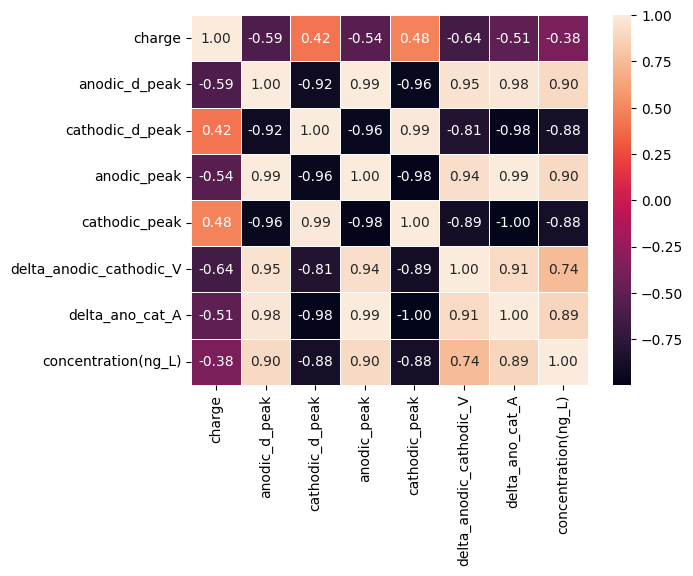

In [12]:
df = pd.read_csv('/home/pedro/Documentos/Workspace/heart_attack_analysis/data/troponin_concentration.csv', index_col=0)
df.head()
correlation = df.corr()
sn.heatmap(correlation, annot=True, fmt='.2f', linewidths=.6)

In [13]:
# Como a carga apresenta baixa correlação, pode-se excluí-la
df_final = df.drop(['charge'], axis=1)

In [14]:
df_final.head()

,anodic_d_peak,cathodic_d_peak,anodic_peak,cathodic_peak,delta_anodic_cathodic_V,delta_ano_cat_A,concentration(ng_L)
0,574.549285,-776.727378,82.78919,-121.886,0.183673,204.67519,600.0
1,595.734679,-736.288308,84.18736,-114.475,0.199645,198.66236,1000.0
2,566.088223,-792.962771,82.22851,-122.168,0.177684,204.39651,1200.0
3,631.517141,-783.258857,90.86034,-128.999,0.215617,219.85934,2000.0
4,594.717561,-806.642917,87.18122,-129.212,0.193656,216.39322,2500.0


In [179]:
# Separando X e Y para regressão
Y = df_final.iloc[:,-1]
X = df_final[['anodic_peak']]

In [180]:
Y.head()

0     600.0
1    1000.0
2    1200.0
3    2000.0
4    2500.0
Name: concentration(ng_L), dtype: float64

In [181]:
X.head()

,anodic_peak
0,82.78919
1,84.18736
2,82.22851
3,90.86034
4,87.18122


## Regressão Linear

In [182]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [244]:
def calculate_coeff_determination(lr, x, y, poly = None):
    if (poly != None):
        features = poly.fit_transform(x.reshape(-1,1))
        r_sq = lr.score(features, y)
    else:
        r_sq = lr.score(x, y)
    return r_sq

In [184]:
lr = LinearRegression()

#Treinando o Modelo
lr.fit(x_train,y_train)
#Verificando o resultado
r_sq = lr.score(X.values, Y.values)
print('Coefficient of determination(R²):', r_sq)

Coefficient of determination(R²): 0.7939556936688819


In [185]:
# Avaliando a performance do modelo

# Intercepto
print('Intercepto:', lr.intercept_)

Intercepto: -39994.395076756446


In [263]:
def get_coefficients(model_regression):
    # Observando os coeficientes
    coeff_df = pd.DataFrame(model_regression.coef_, columns=['Coefficient'])
    coeff_df['Intercept'] = lr.intercept_
    return coeff_df

In [187]:
def get_regression_metrics(model_linear, y_test, x_test, model_poly = None):
    out = {
        'MAE': 0,
        'MSE': 0,
        'RMSE':0
    }
    if (model_poly != None):
        x_test = model_poly.fit_transform(x_test.reshape(-1, 1))
        
    y_pred = model_linear.predict(x_test)
    out['MAE'] = metrics.mean_absolute_error(y_test, y_pred)
    out['MSE'] = metrics.mean_squared_error(y_test, y_pred)
    out['RMSE'] = np.sqrt(out['MSE'])
    return out

In [204]:
def print_metrics(metrics:dict):
    for key in metrics.keys():
        print(f'{key}: {metrics[key]}')

In [188]:
# Observando os coeficientes
coeff_df = pd.DataFrame(lr.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
anodic_peak,471.410023


In [189]:
# Imprimindo os erros
y_pred = lr.predict(x_test)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 2691.7486122900445
MSE: 7313473.705545721
RMSE: 2704.343488824177


In [190]:
x = np.concatenate((x_train, x_test))
y_true = np.concatenate((y_train, y_test))
y_pred = lr.predict(x)
print(x.shape)
print(y_true.shape)
print(y_pred.shape)

(9, 1)
(9,)
(9,)


In [191]:
print(x)

[[ 84.18736]
 [ 87.18122]
 [118.7837 ]
 [103.6226 ]
 [ 90.86034]
 [ 82.78919]
 [100.9126 ]
 [112.3159 ]
 [ 82.22851]]


## Polynomial Regression

In [193]:
from sklearn.preprocessing import PolynomialFeatures
degrees = [2, 3, 4]

for degree in degrees:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(x_train.values.reshape(-1, 1))
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, y_train)
    mectrics = get_regression_metrics(poly_reg_model, y_test.values, x_test.values, poly)
    r_sq = calculate_coeff_determination(poly_reg_model, X, Y, poly)
    
    print("Polynom Degree", degree)
    print('Coefficient of determination(R²):', r_sq)
    print('MAE:', mectrics['MAE'])
    print('MSE:', mectrics['MSE'])
    print('RMSE:', mectrics['RMSE'])
    print('------------------------------------------')

Polynom Degree 2
Coefficient of determination(R²): 0.9616336283436017
MAE: 1607.2008164797735
MSE: 3712645.595315737
RMSE: 1926.8226683625396
------------------------------------------
Polynom Degree 3
Coefficient of determination(R²): 0.9934452544060925
MAE: 844.2958626586478
MSE: 726721.6255160184
RMSE: 852.4796921428793
------------------------------------------
Polynom Degree 4
Coefficient of determination(R²): 0.9701592283307581
MAE: 1929.0101559627801
MSE: 4502841.227820888
RMSE: 2121.989921705777
------------------------------------------


## Lasso Regression

In [200]:
lasso = Lasso(alpha=0.1)
lasso.fit(x_train, y_train)

Lasso(alpha=0.1)

In [201]:
# Imprimindo os coeficientes
lasso_coeficients = get_coefficients(lasso, X.columns)
lasso_coeficients

,Coefficient,intercept
anodic_peak,471.409336,-39994.395077


In [210]:
# Avaliando o modelo
lasso_metrics = get_regression_metrics(lasso, y_test, x_test, None)
print_metrics(lasso_metrics)
r_square = calculate_coeff_determination(lasso, X, Y, None)
print(f"Coefficient of determination: {r_square}")

MAE: 2691.7382645361467
MSE: 7313417.3546164315
RMSE: 2704.3330702072244
Coefficient of determination: 0.7939560504743787


In [213]:
# Avaliando a regressão Lasso polinomial
degrees = [2, 3, 4]

for degree in degrees:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(x_train.values.reshape(-1, 1))
    poly_reg_model = Lasso(alpha=0.1)
    poly_reg_model.fit(poly_features, y_train)
    mectrics = get_regression_metrics(poly_reg_model, y_test.values, x_test.values, poly)
    r_sq = calculate_coeff_determination(poly_reg_model, X, Y, poly)
    
    print("Polynom Degree", degree)
    print('Coefficient of determination(R²):', r_sq)
    print('MAE:', mectrics['MAE'])
    print('MSE:', mectrics['MSE'])
    print('RMSE:', mectrics['RMSE'])
    print('------------------------------------------')


Polynom Degree 2
Coefficient of determination(R²): 0.9612057265156658
MAE: 1530.7751454897225
MSE: 3704015.7629283825
RMSE: 1924.5819709558702
------------------------------------------
Polynom Degree 3
Coefficient of determination(R²): 0.9647631077938313
MAE: 1536.7786909067363
MSE: 3434946.9752652966
RMSE: 1853.3609943195893
------------------------------------------
Polynom Degree 4
Coefficient of determination(R²): 0.9679832857587409
MAE: 1457.8133454152558
MSE: 3136250.2357780403
RMSE: 1770.9461414108675
------------------------------------------


# Huber Regressor 

In [229]:
# Avaliando a regressão Lasso polinomial
degrees = [1, 2, 3, 4]

for degree in degrees:
    poly = None
    if (degree != 1):
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        poly_features = poly.fit_transform(x_train.values.reshape(-1, 1))
        poly_reg_model = HuberRegressor(alpha=0.001)
        poly_reg_model.fit(poly_features, y_train)
    else:
        poly_reg_model = HuberRegressor(alpha=0.001)
        poly_reg_model.fit(x_train.values, y_train)
    mectrics = get_regression_metrics(poly_reg_model, y_test.values, x_test.values, poly)
    r_sq = calculate_coeff_determination(poly_reg_model, X, Y, poly)
    
    print("Polynom Degree", degree)
    print('Coefficient of determination(R²):', r_sq)
    print_metrics(mectrics)
    print('------------------------------------------')

Polynom Degree 1
Coefficient of determination(R²): 0.6614598304891594
MAE: 1350.4436731185633
MSE: 1948194.0893109543
RMSE: 1395.777234844785
------------------------------------------
Polynom Degree 2
Coefficient of determination(R²): 0.8273038975212534
MAE: 2871.5295445756333
MSE: 9488267.121190084
RMSE: 3080.303089176467
------------------------------------------
Polynom Degree 3
Coefficient of determination(R²): 0.9709557631395042
MAE: 1173.17408770441
MSE: 2750095.116026192
RMSE: 1658.3410734906713
------------------------------------------
Polynom Degree 4
Coefficient of determination(R²): 0.8849520019461118
MAE: 2422.4987195690665
MSE: 8810542.746194264
RMSE: 2968.2558424425383
------------------------------------------


## RASNAC Regressor

In [230]:
losses = ['squared_error', 'absolute_error']
for loss in losses:
    print(f"Loss: {loss}")
    print("**"*10)
    for degree in degrees:
        poly = None
        if (degree != 1):
            poly = PolynomialFeatures(degree=degree, include_bias=False)
            poly_features = poly.fit_transform(x_train.values.reshape(-1, 1))
            poly_reg_model = RANSACRegressor(loss=loss)
            poly_reg_model.fit(poly_features, y_train)
        else:
            poly_reg_model = RANSACRegressor(loss=loss)
            poly_reg_model.fit(x_train.values, y_train)
        mectrics = get_regression_metrics(poly_reg_model, y_test.values, x_test.values, poly)
        r_sq = calculate_coeff_determination(poly_reg_model, X, Y, poly)
        
        print("Polynom Degree", degree)
        print('Coefficient of determination(R²):', r_sq)
        print_metrics(mectrics)
        print('------------------------------------------')

Loss: squared_error
********************
Polynom Degree 1
Coefficient of determination(R²): 0.5220966120711406
MAE: 1941.198488389562
MSE: 5263450.59003434
RMSE: 2294.2211292799
------------------------------------------
Polynom Degree 2
Coefficient of determination(R²): 0.896379032507163
MAE: 2722.458495776111
MSE: 7531558.38924727
RMSE: 2744.3684864185548
------------------------------------------
Polynom Degree 3
Coefficient of determination(R²): 0.9912786290715365
MAE: 973.394438431249
MSE: 986406.1463982903
RMSE: 993.179815742492
------------------------------------------
Polynom Degree 4
Coefficient of determination(R²): 0.9704404959239955
MAE: 1930.172788452357
MSE: 3725579.1819087006
RMSE: 1930.175945842425
------------------------------------------
Loss: absolute_error
********************
Polynom Degree 1
Coefficient of determination(R²): 0.4714231599618155
MAE: 2014.3264741727617
MSE: 6518293.885762322
RMSE: 2553.094962151295
------------------------------------------
Polyno

## SGD Regressor

In [249]:
from sklearn.preprocessing import StandardScaler

param = {
    'loss': ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'alpha': [alpha / 100.0 for alpha in range(1, 11)],
    'epsilon': [epsilon / 100 for epsilon in range(1,11)],
    'learning_rate': ['constant', 'adaptive', 'optimal', 'invscaling']
}

best_param = {
    'loss': None,
    'alpha':None,
    'epsilon': None,
    'learning_rate': None,
    'degree': None
}

min_rmse = np.inf
best_r_square = 0
best_metrics = {}
best_model = None

losses = param['loss']
alphas = param['alpha']
epsilons = param['epsilon']
lrs = param['learning_rate']

scaler = StandardScaler()
new_x = scaler.fit_transform(X.values, Y.values)
n_x_train, n_x_test, n_y_train, n_y_test = train_test_split(new_x, Y, test_size=0.2, random_state=0)
print(new_x.shape)

for loss in losses:
    for alpha in alphas:
        for epsilon in epsilons:
            for l in lrs:
                print(f"Loss: {loss}, Apha: {alpha}, Epsilon: {epsilon}, Learning rate: {l}")
                print("**"*10)
                for degree in degrees:
                    poly = None
                    if (degree != 1):
                        poly = PolynomialFeatures(degree=degree, include_bias=False)
                        poly_features = poly.fit_transform(n_x_train.reshape(-1, 1))
                        poly_reg_model = SGDRegressor(loss=loss, alpha=alpha, learning_rate=l, epsilon=epsilon)
                        poly_reg_model.fit(poly_features, n_y_train)
                    else:
                        poly_reg_model = SGDRegressor(loss=loss, alpha=alpha, learning_rate=l, epsilon=epsilon)
                        poly_reg_model.fit(n_x_train, n_y_train)
                    mectrics = get_regression_metrics(poly_reg_model, n_y_test, n_x_test, poly)
                    r_sq = calculate_coeff_determination(poly_reg_model, new_x, Y, poly)
                    
                    print("Polynom Degree", degree)
                    print('Coefficient of determination(R²):', r_sq)
                    print_metrics(mectrics)
                    print('------------------------------------------')
                    
                    if (mectrics['RMSE'] < min_rmse):
                        min_rmse = mectrics['RMSE']
                        best_metrics = mectrics
                        best_param['alpha'] = alpha
                        best_param['epsilon'] = epsilon
                        best_param['learning_rate'] = l
                        best_param['loss'] = loss
                        best_param['degree'] = degree
                        best_r_square = r_sq
                        best_model = poly_reg_model
                                        
print(f'Best R²: {best_r_square}')
print_metrics(best_metrics)
print(best_param)

(9, 1)
Loss: squared_error, Apha: 0.01, Epsilon: 0.01, Learning rate: constant
********************
Polynom Degree 1
Coefficient of determination(R²): 0.7973530225770269
MAE: 2587.569028325373
MSE: 6752158.907038311
RMSE: 2598.4916599901394
------------------------------------------
Polynom Degree 2
Coefficient of determination(R²): 0.9624479077825028
MAE: 1605.5914289839525
MSE: 3576736.467347032
RMSE: 1891.2261809067238
------------------------------------------
Polynom Degree 3
Coefficient of determination(R²): 0.9937948005247785
MAE: 815.1198623532978
MSE: 666206.1111791993
RMSE: 816.2145007160797
------------------------------------------
Polynom Degree 4
Coefficient of determination(R²): 0.9956876239749615
MAE: 547.5195869773686
MSE: 315020.4938519186
RMSE: 561.2668650935299
------------------------------------------
Loss: squared_error, Apha: 0.01, Epsilon: 0.01, Learning rate: adaptive
********************
Polynom Degree 1
Coefficient of determination(R²): 0.797100074494238
MAE

In [267]:
best_coefficients = get_coefficients(best_model)
best_coefficients

,Coefficient,Intercept
0,1857.714397,-39994.395077
1,569.964854,-39994.395077
2,1045.024500,-39994.395077
3,580.639432,-39994.395077


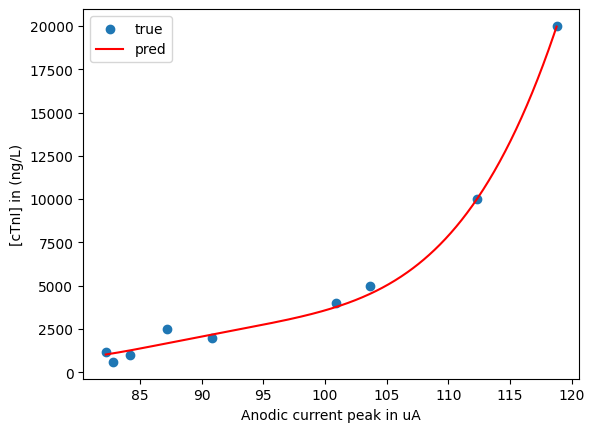

In [279]:
# Plotando para verificar o modelo
import matplotlib.pyplot as plt
plt.Figure()
plt.scatter(scaler.inverse_transform(new_x), Y, label = 'true')
x_values = np.linspace(X.min(), X.max(), 500)
new_x_values = scaler.transform(x_values)
poly = PolynomialFeatures(degree=4, include_bias=False)
poly_features = poly.fit_transform(new_x_values.reshape(-1, 1))
pred = best_model.predict(poly_features)
plt.plot(scaler.inverse_transform(new_x_values), pred, color='red', label = 'pred')
plt.ylabel('[cTnI] in (ng/L)')
plt.xlabel('Anodic current peak in uA')
plt.legend()
plt.show()


## Utilizando o Support Vector Regression

In [295]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param = {
    'kernel': ['poly'],
    'C': [c for c in range(1,11)],
    'degree': [1, 2, 3, 4]
}

base_regressor = SVR(kernel='poly', degree=4)
n_y_train = StandardScaler().fit_transform(n_y_train)

base_regressor.fit(n_x_train, n_y_train)
print(f"Best Parameters: {base_regressor.get_params()}" )
results = get_regression_metrics(base_regressor, n_y_test, n_x_test)
print_metrics(results)

ValueError: Expected 2D array, got 1D array instead:
array=[ 1000.  2500. 20000.  5000.  2000.   600.  4000.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.